In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,decode_predictions
import numpy 
import pandas as pd
import os
import matplotlib.pyplot as plt
import statistics

image_size = (128, 128)
batch_size = 32

model_mobileNet =  tf.keras.applications.MobileNet(
    input_shape=image_size + (3,),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=31,
    classifier_activation="softmax",
)


In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "age_prediction/train",
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "age_prediction/train",
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)

Found 40440 files belonging to 31 classes.
Using 32352 files for training.
Found 40440 files belonging to 31 classes.
Using 8088 files for validation.


In [4]:
data_augmentation = keras.Sequential(
    [
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.1),
    ]
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [10]:
epochs = 50
model_mobileNet = keras.models.load_model('mobile_net_for_PIS_save_at_50.h5')
model_mobileNet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
callbacks_for_mobile_net = [
    keras.callbacks.ModelCheckpoint("2mobile_net_for_PIS_save_at_{epoch}.h5"),
]
model_mobileNet.fit(
    train_ds, epochs=epochs, callbacks=callbacks_for_mobile_net, validation_data=val_ds,
)#0.97 точность на обучающей и 0.76 на тестовой

Epoch 1/50
1011/1011 [==============================] - 1461s 1s/step - loss: 1.2268 - accuracy: 0.7531 - val_loss: 1.2092 - val_accuracy: 0.7428
Epoch 2/50
1011/1011 [==============================] - 1463s 1s/step - loss: 0.6710 - accuracy: 0.8307 - val_loss: 1.5622 - val_accuracy: 0.6811
Epoch 3/50
1011/1011 [==============================] - 1468s 1s/step - loss: 0.4413 - accuracy: 0.8780 - val_loss: 1.7960 - val_accuracy: 0.6606
Epoch 4/50
1011/1011 [==============================] - 1473s 1s/step - loss: 0.3672 - accuracy: 0.8960 - val_loss: 2.1478 - val_accuracy: 0.6053
Epoch 5/50
1011/1011 [==============================] - 1481s 1s/step - loss: 0.3508 - accuracy: 0.8969 - val_loss: 2.1157 - val_accuracy: 0.6098
Epoch 6/50
1011/1011 [==============================] - 1485s 1s/step - loss: 0.3102 - accuracy: 0.9034 - val_loss: 2.4154 - val_accuracy: 0.5474
Epoch 7/50
1011/1011 [==============================] - 1481s 1s/step - loss: 0.2895 - accuracy: 0.9101 - val_loss: 2.4222 -

KeyboardInterrupt: 

In [6]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x 
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual]) 
        previous_block_activation = x  
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(31, activation="softmax")(x)
    return keras.Model(inputs, outputs)

my_model = make_model(input_shape=image_size + (3,))

In [18]:
my_model.compile(optimizer = keras.optimizers.Adam(1e-3),
                 loss = "sparse_categorical_crossentropy",
                 metrics = ["accuracy"])                            
epochs = 50
batch_size = 32
callbacks_for_my_model = [
    keras.callbacks.ModelCheckpoint("my_model{epoch}.h5"),
]
my_model.fit(
    train_ds, epochs=epochs, callbacks=callbacks_for_my_model, validation_data=val_ds,
)

Epoch 1/50
1011/1011 [==============================] - 2010s 2s/step - loss: 3.0481 - accuracy: 0.0916 - val_loss: 3.2155 - val_accuracy: 0.0702
Epoch 2/50
1011/1011 [==============================] - 2052s 2s/step - loss: 2.8859 - accuracy: 0.1133 - val_loss: 3.2940 - val_accuracy: 0.0711
Epoch 3/50
1011/1011 [==============================] - 2059s 2s/step - loss: 2.7268 - accuracy: 0.1310 - val_loss: 3.3548 - val_accuracy: 0.0802
Epoch 4/50
1011/1011 [==============================] - 2058s 2s/step - loss: 2.5701 - accuracy: 0.1584 - val_loss: 3.4778 - val_accuracy: 0.0843
Epoch 5/50
1011/1011 [==============================] - 2049s 2s/step - loss: 2.4439 - accuracy: 0.1807 - val_loss: 3.7571 - val_accuracy: 0.0843
Epoch 6/50
1011/1011 [==============================] - 2053s 2s/step - loss: 2.3423 - accuracy: 0.2100 - val_loss: 3.9491 - val_accuracy: 0.0875
Epoch 7/50
1011/1011 [==============================] - 2076s 2s/step - loss: 2.2553 - accuracy: 0.2300 - val_loss: 4.0351 -

In [4]:
model_mobileNet = keras.models.load_model('mobile_net_for_PIS_save_at_50.h5')
my_model = keras.models.load_model('my_model40.h5')

In [39]:
prediction_my_model = []
prediction_mobilenet = []
true_age = []
for i in range(20,51):
    k = 0
    for j in os.listdir("age_prediction_zapas/test/0"+str(i)):
        k+=1
        img_path = "age_prediction_zapas/test/0"+str(i)+"/"+j
        img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  
        predictions = my_model.predict(img_array)
        prediction_my_model.append(20+numpy.argmax(predictions[0]))
        prediction2 = model_mobileNet.predict(img_array)
        prediction_mobilenet.append(20+numpy.argmax(prediction2[0]))
        true_age.append(int(img_path[27])*10+int(img_path[28]))
        print("Истинный возраст: {}{}".format(img_path[27],img_path[28]))
        print("My_model:C вероятностью {} на этой фотографии человек {} лет\n".format(max(predictions[0]),20+numpy.argmax(predictions[0])))
        print("MobileNet:C вероятностью {} на этой фотографии человек {} лет\n".format(max(prediction2[0]),20+numpy.argmax(prediction2[0])))
        if(k==9):
            break

Истинный возраст: 20
My_model:C вероятностью 0.5883870720863342 на этой фотографии человек 26 лет

MobileNet:C вероятностью 0.6184832453727722 на этой фотографии человек 23 лет

Истинный возраст: 20
My_model:C вероятностью 0.7242211699485779 на этой фотографии человек 31 лет

MobileNet:C вероятностью 0.2771480083465576 на этой фотографии человек 25 лет

Истинный возраст: 20
My_model:C вероятностью 0.6628532409667969 на этой фотографии человек 23 лет

MobileNet:C вероятностью 0.9646807312965393 на этой фотографии человек 36 лет

Истинный возраст: 20
My_model:C вероятностью 0.8397745490074158 на этой фотографии человек 26 лет

MobileNet:C вероятностью 0.556792676448822 на этой фотографии человек 30 лет

Истинный возраст: 20
My_model:C вероятностью 0.593115508556366 на этой фотографии человек 20 лет

MobileNet:C вероятностью 0.8413580060005188 на этой фотографии человек 22 лет

Истинный возраст: 20
My_model:C вероятностью 0.4096742570400238 на этой фотографии человек 24 лет

MobileNet:C в

Истинный возраст: 25
My_model:C вероятностью 0.7637608051300049 на этой фотографии человек 27 лет

MobileNet:C вероятностью 0.7667896747589111 на этой фотографии человек 32 лет

Истинный возраст: 25
My_model:C вероятностью 0.9342343807220459 на этой фотографии человек 22 лет

MobileNet:C вероятностью 0.9024671316146851 на этой фотографии человек 21 лет

Истинный возраст: 25
My_model:C вероятностью 0.9933344125747681 на этой фотографии человек 22 лет

MobileNet:C вероятностью 0.8053618669509888 на этой фотографии человек 27 лет

Истинный возраст: 25
My_model:C вероятностью 0.8125818967819214 на этой фотографии человек 34 лет

MobileNet:C вероятностью 0.6637347936630249 на этой фотографии человек 32 лет

Истинный возраст: 25
My_model:C вероятностью 0.6414862275123596 на этой фотографии человек 31 лет

MobileNet:C вероятностью 0.9887568354606628 на этой фотографии человек 31 лет

Истинный возраст: 25
My_model:C вероятностью 0.9974798560142517 на этой фотографии человек 27 лет

MobileNet:C

Истинный возраст: 30
My_model:C вероятностью 0.6482850909233093 на этой фотографии человек 42 лет

MobileNet:C вероятностью 0.682621419429779 на этой фотографии человек 29 лет

Истинный возраст: 30
My_model:C вероятностью 0.9822341799736023 на этой фотографии человек 37 лет

MobileNet:C вероятностью 0.7581444382667542 на этой фотографии человек 44 лет

Истинный возраст: 30
My_model:C вероятностью 0.4621812403202057 на этой фотографии человек 26 лет

MobileNet:C вероятностью 0.35946762561798096 на этой фотографии человек 47 лет

Истинный возраст: 30
My_model:C вероятностью 0.9996986389160156 на этой фотографии человек 21 лет

MobileNet:C вероятностью 0.5206941962242126 на этой фотографии человек 45 лет

Истинный возраст: 30
My_model:C вероятностью 0.7749346494674683 на этой фотографии человек 36 лет

MobileNet:C вероятностью 0.9372386336326599 на этой фотографии человек 32 лет

Истинный возраст: 30
My_model:C вероятностью 0.7860616445541382 на этой фотографии человек 27 лет

MobileNet:C

Истинный возраст: 35
My_model:C вероятностью 0.3955715000629425 на этой фотографии человек 24 лет

MobileNet:C вероятностью 0.5091273784637451 на этой фотографии человек 21 лет

Истинный возраст: 35
My_model:C вероятностью 0.36739104986190796 на этой фотографии человек 43 лет

MobileNet:C вероятностью 0.7154983282089233 на этой фотографии человек 37 лет

Истинный возраст: 35
My_model:C вероятностью 0.5413191914558411 на этой фотографии человек 28 лет

MobileNet:C вероятностью 0.584719181060791 на этой фотографии человек 33 лет

Истинный возраст: 35
My_model:C вероятностью 0.9923661351203918 на этой фотографии человек 33 лет

MobileNet:C вероятностью 0.8931015133857727 на этой фотографии человек 32 лет

Истинный возраст: 36
My_model:C вероятностью 0.9997337460517883 на этой фотографии человек 41 лет

MobileNet:C вероятностью 0.7456097602844238 на этой фотографии человек 23 лет

Истинный возраст: 36
My_model:C вероятностью 0.9847091436386108 на этой фотографии человек 37 лет

MobileNet:C

Истинный возраст: 40
My_model:C вероятностью 0.39523881673812866 на этой фотографии человек 37 лет

MobileNet:C вероятностью 0.5295024514198303 на этой фотографии человек 22 лет

Истинный возраст: 40
My_model:C вероятностью 0.45301732420921326 на этой фотографии человек 28 лет

MobileNet:C вероятностью 0.960574746131897 на этой фотографии человек 37 лет

Истинный возраст: 41
My_model:C вероятностью 0.5999376177787781 на этой фотографии человек 44 лет

MobileNet:C вероятностью 0.9425957202911377 на этой фотографии человек 34 лет

Истинный возраст: 41
My_model:C вероятностью 0.9880115389823914 на этой фотографии человек 41 лет

MobileNet:C вероятностью 0.99226975440979 на этой фотографии человек 21 лет

Истинный возраст: 41
My_model:C вероятностью 0.5475050210952759 на этой фотографии человек 36 лет

MobileNet:C вероятностью 0.7995498776435852 на этой фотографии человек 47 лет

Истинный возраст: 41
My_model:C вероятностью 0.7719531059265137 на этой фотографии человек 44 лет

MobileNet:C 

Истинный возраст: 46
My_model:C вероятностью 0.6305310726165771 на этой фотографии человек 44 лет

MobileNet:C вероятностью 0.611640214920044 на этой фотографии человек 36 лет

Истинный возраст: 46
My_model:C вероятностью 0.7678493857383728 на этой фотографии человек 45 лет

MobileNet:C вероятностью 0.6719145178794861 на этой фотографии человек 40 лет

Истинный возраст: 46
My_model:C вероятностью 0.9875307679176331 на этой фотографии человек 35 лет

MobileNet:C вероятностью 0.5753973722457886 на этой фотографии человек 45 лет

Истинный возраст: 46
My_model:C вероятностью 0.98886638879776 на этой фотографии человек 25 лет

MobileNet:C вероятностью 0.7445917725563049 на этой фотографии человек 44 лет

Истинный возраст: 46
My_model:C вероятностью 0.9746021032333374 на этой фотографии человек 42 лет

MobileNet:C вероятностью 0.6577064990997314 на этой фотографии человек 33 лет

Истинный возраст: 46
My_model:C вероятностью 0.45795223116874695 на этой фотографии человек 45 лет

MobileNet:C в

In [74]:
sum_for_my = 0
sum_for_mn = 0
for i in range(len(true_age)):
    sum_for_my  += abs(prediction_my_model[i] - true_age[i])
    sum_for_mn += abs(prediction_mobilenet[i] - true_age[i])
print("Средняя абсолютная ошибка для моей модели: {}".format(sum_for_my/len(true_age)))
print("Средняя абсолютная ошибка для MobileNet: {}".format(sum_for_mn/len(true_age)))

Средняя абсолютная ошибка для моей модели: 6.612903225806452
Средняя абсолютная ошибка для MobileNet: 8.089605734767025


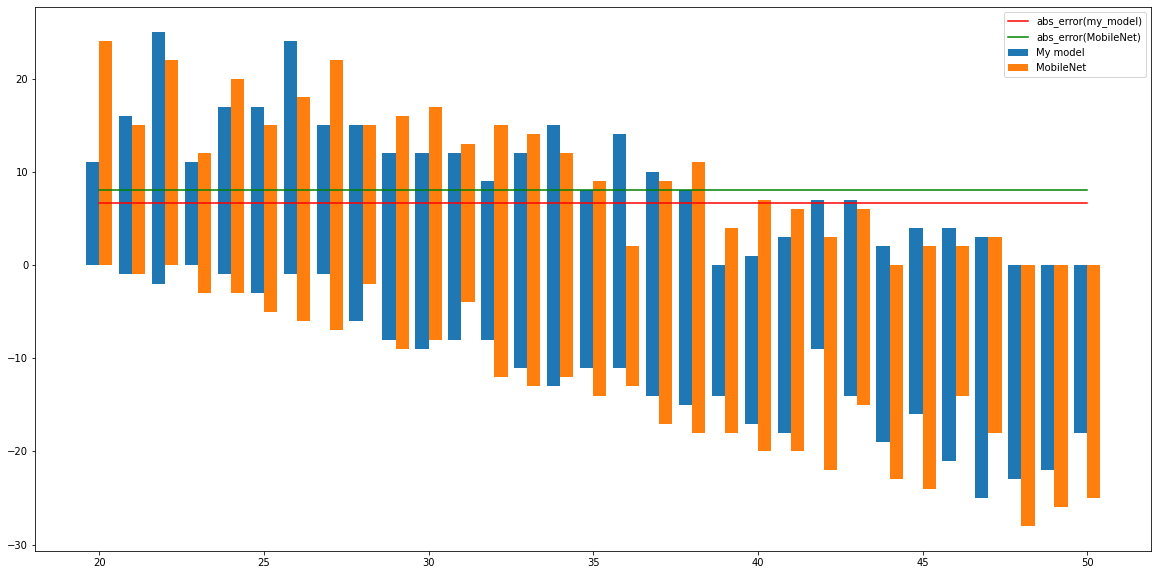

In [76]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot()
 
w = 0.4
my_error = [prediction_my_model[i] - true_age[i] for i in range(len(true_age))]
mobilenet_error = [prediction_mobilenet[i] - true_age[i] for i in range(len(true_age))]
arr_for_graph_minus = [true_age[i] - w/2 for i in range(len(true_age))]
arr_for_graph_plus = [true_age[i] + w/2 for i in range(len(true_age))]

ax.bar(arr_for_graph_minus, my_error, width=w,label = 'My model')
ax.bar(arr_for_graph_plus , mobilenet_error, width=w,label = 'MobileNet')
ax.plot(true_age,[sum_for_my/len(true_age) for i in range(len(true_age))],color = 'red',label ='abs_error(my_model)')
ax.plot(true_age,[sum_for_mn/len(true_age) for i in range(len(true_age))],color = 'green',label ='abs_error(MobileNet)')
ax.legend()
plt.show()